In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
path = '../Data/car_dataset_sample/'
#path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])

print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  1897
Image_labels: 1897


In [3]:
from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(img_labels)

# 인코딩한 데이터로 변환
le_encoded = le.transform(img_labels)

# 결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])

# 아래 코드를 실행시키면 인코딩된 class를 확인할 수 있습니다.
new_cat


,result
0,143
1,143
2,143
3,142
4,142
...,...
1892,80
1893,80
1894,84
1895,84


In [4]:
trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = new_cat
train = trn_df
train

,image_id,dir,label
0,C_211111_SS_097_21_RE_B_T_03_013.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,143
1,C_211111_SS_097_21_RE_B_P_01_031.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,143
2,C_211111_SS_097_21_RE_B_P_01_058.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2021_...,143
3,C_210914_SS_097_20_WH_A_P_01_062.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,142
4,C_210914_SS_097_20_WH_A_T_02_003.jpg,../Data/car_dataset_sample/SS_쌍용/097_티볼리/2020_...,142
...,...,...,...
1892,C_211001_KG_044_17_BL_A_P_01_045.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,80
1893,C_211001_KG_044_17_BL_A_P_01_050.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/201...,80
1894,C_210930_KG_044_21_WH_A_P_01_036.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,84
1895,C_210930_KG_044_21_WH_A_P_01_033.jpg,../Data/car_dataset_sample/KG_한국지엠/044_다마스/202...,84


In [7]:
first = le.inverse_transform([360])
first

array(['VO_078_18'], dtype='<U9')

In [15]:
train.label.value_counts()

24     3566
174    2755
229    2721
201    2563
259    2471
       ... 
193      91
72       90
61       89
289      79
192      70
Name: label, Length: 370, dtype: int64

In [7]:
print(len(train.label))

290400


In [62]:
print(train.dir.values[0])

Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B


In [60]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds_split = folds.split(np.arange(train.shape[0]), train.label.values)
for fold, (trn_idx, val_idx) in enumerate(folds_split):
#print(f'trn_idx:{trn_idx}, val_idx: {val_idx}, fold: {fold}')
    print(f'{fold}st : trn: {trn_idx}')
    print(f'{fold}st : val: {val_idx}')

train_ = train.loc[trn_idx,:].reset_index(drop=True)
valid_ = train.loc[val_idx,:].reset_index(drop=True)
train_data_root = train.dir.values[trn_idx] #trn_idx에 맞는 dir 뽑기
valid_data_root = train.dir.values[val_idx]
#print(train_)


0st : trn: [     0      1      2 ... 257734 257735 257739]
0st : val: [     6      7     26 ... 257736 257737 257738]
1st : trn: [     0      2      4 ... 257737 257738 257739]
1st : val: [     1      3      5 ... 257728 257733 257735]
2st : trn: [     0      1      2 ... 257737 257738 257739]
2st : val: [     4      8     11 ... 257713 257723 257729]
3st : trn: [     0      1      3 ... 257736 257737 257738]
3st : val: [     2     20     21 ... 257732 257734 257739]
4st : trn: [     1      2      3 ... 257737 257738 257739]
4st : val: [     0      9     12 ... 257716 257717 257724]


array(['Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       'Data/car_data/car/1.Training/원천데이터/VO_폭스바겐/078_파사트/2018_흰색_트림B',
       ...,
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A',
       'Data/car_data/car/1.Training/원천데이터/BM_BMW/039_X5/2021_검정_트림A'],
      dtype=object)

In [10]:
train.label.nunique()

144

In [50]:
print(train.shape[0])
k = np.arange(train.shape[0])
k

257740


array([     0,      1,      2, ..., 257737, 257738, 257739])

In [33]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[10, 20], [30, 40], [11, 22], [33, 44]])
y = np.array([1, 1, 0, 0])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf.get_n_splits(X, y))

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

2
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


In [5]:
dist.destroy_process_group()

NameError: name 'dist' is not defined

In [6]:
project_name = 'test02_batch128_car_classification'
user = 'hojunking'
run_name = 'test02_car_classification_efficientnet_lite0'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Training start with epoch 30 



epoch 0 loss: 4.8742: 100%|███████████████████████████████████████| 124/124 [01:06<00:00,  1.87it/s]

train accuracy = 0.05518
[[ 2  0  0 ...  1  0  0]
 [ 1  3  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0 10]]



epoch 0 loss: 4.8798: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 12.57it/s]


validation accuracy = 0.01579
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


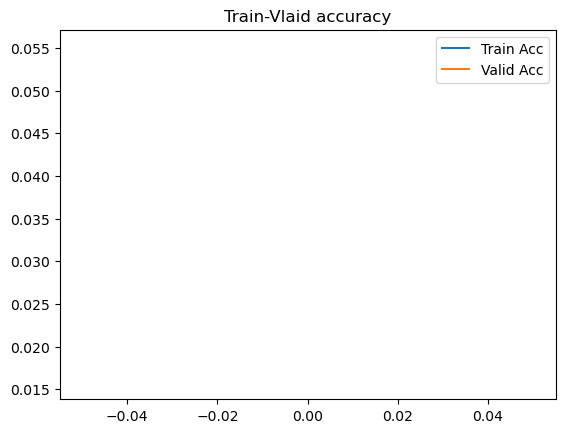

epoch 1 loss: 4.5391: 100%|███████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]

train accuracy = 0.24545
[[ 4  0  0 ...  0  0  0]
 [ 3  7  0 ...  0  0  0]
 [ 1  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  1]
 [ 0  0  0 ...  0  1 29]]



epoch 1 loss: 4.7465: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 12.17it/s]


validation accuracy = 0.03947
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


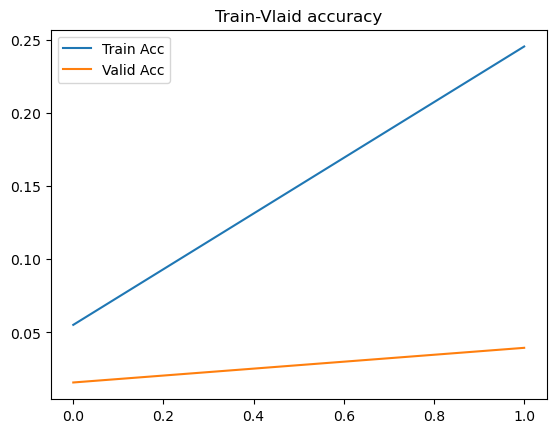

epoch 2 loss: 4.0603: 100%|███████████████████████████████████████| 124/124 [00:57<00:00,  2.15it/s]


train accuracy = 0.33813
[[18  0  0 ...  0  0  0]
 [ 2 32  0 ...  0  0  0]
 [ 1  0 36 ...  0  1  0]
 ...
 [ 2  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  8  4]
 [ 0  0  0 ...  0  0 41]]


epoch 2 loss: 4.5731: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 11.89it/s]


validation accuracy = 0.03947
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 2]]


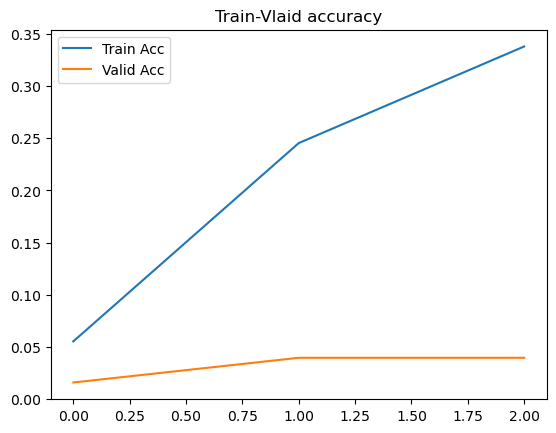

epoch 3 loss: 3.4250: 100%|███████████████████████████████████████| 124/124 [00:56<00:00,  2.19it/s]

train accuracy = 0.39912
[[35  0  0 ...  0  0  0]
 [ 7 37  0 ...  0  0  0]
 [ 0  0 43 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  1  0 ...  0  3 15]
 [ 0  0  0 ...  0  0 53]]



epoch 3 loss: 4.3958: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 12.41it/s]


validation accuracy = 0.04211
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


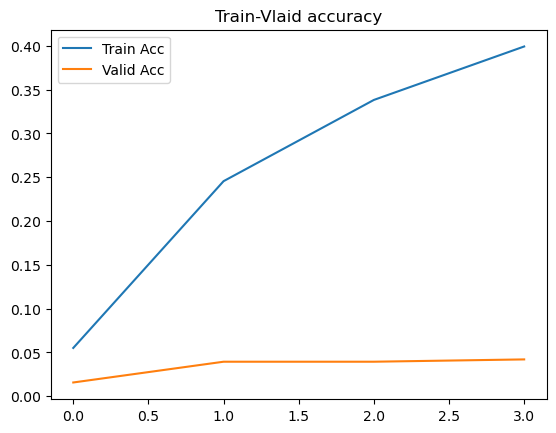

epoch 4 loss: 2.9403: 100%|███████████████████████████████████████| 124/124 [00:58<00:00,  2.12it/s]

train accuracy = 0.48902
[[29  0  0 ...  0  0  0]
 [ 0 46  0 ...  0  0  0]
 [ 0  0 52 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  8 10]
 [ 0  0  0 ...  0  0 54]]



epoch 4 loss: 4.2204: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 11.67it/s]


validation accuracy = 0.07632
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


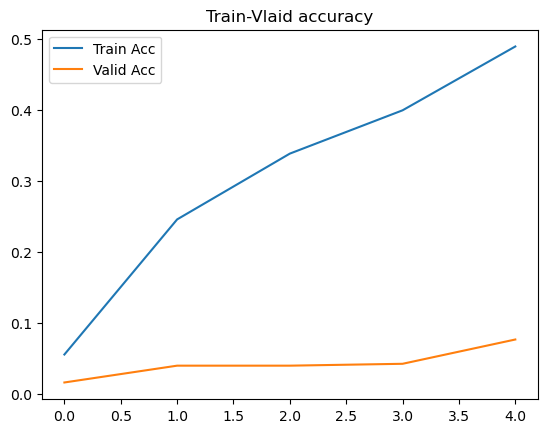

epoch 5 loss: 2.4544: 100%|███████████████████████████████████████| 124/124 [00:58<00:00,  2.12it/s]

train accuracy = 0.57273
[[43  0  0 ...  0  0  0]
 [ 0 54  0 ...  0  0  0]
 [ 0  0 54 ...  0  0  0]
 ...
 [ 1  0  0 ...  5  0  0]
 [ 0  0  2 ...  0 11  8]
 [ 0  0  0 ...  0  0 55]]



epoch 5 loss: 4.0891: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 11.10it/s]


validation accuracy = 0.10263
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


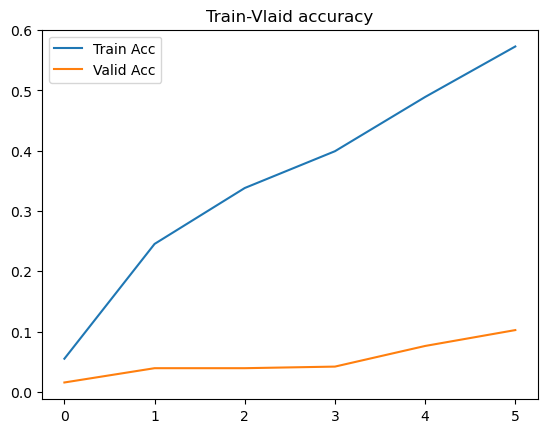

epoch 6 loss: 2.0667: 100%|███████████████████████████████████████| 124/124 [00:58<00:00,  2.13it/s]

train accuracy = 0.66490
[[45  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  1  2 ...  0 19  8]
 [ 0  0  0 ...  0  0 55]]



epoch 6 loss: 3.9877: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 11.25it/s]


validation accuracy = 0.10789
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


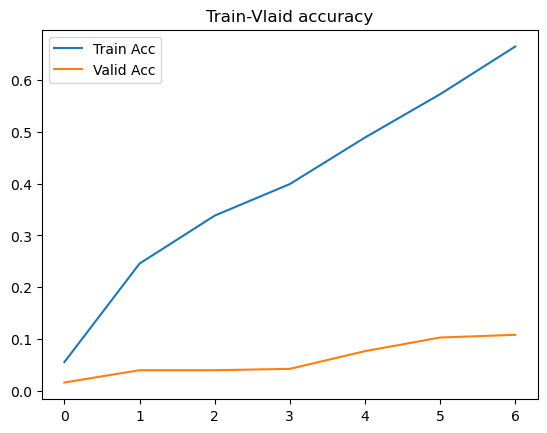

epoch 7 loss: 1.6443: 100%|███████████████████████████████████████| 124/124 [00:58<00:00,  2.12it/s]


train accuracy = 0.72879
[[50  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 1  0  0 ... 16  1  0]
 [ 0  0  0 ...  0 31  6]
 [ 0  0  0 ...  0  0 55]]


epoch 7 loss: 3.8894: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 12.19it/s]


validation accuracy = 0.12895
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


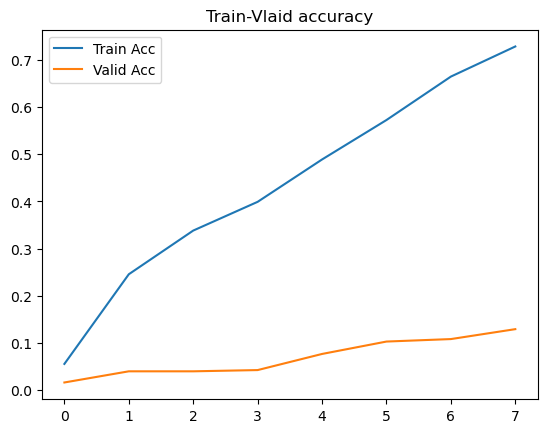

epoch 8 loss: 1.4138: 100%|███████████████████████████████████████| 124/124 [00:56<00:00,  2.18it/s]

train accuracy = 0.79495
[[49  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 1  0  0 ... 22  1  0]
 [ 0  0  1 ...  0 37  5]
 [ 0  0  0 ...  0  0 55]]



epoch 8 loss: 3.7952: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 11.58it/s]


validation accuracy = 0.13947
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


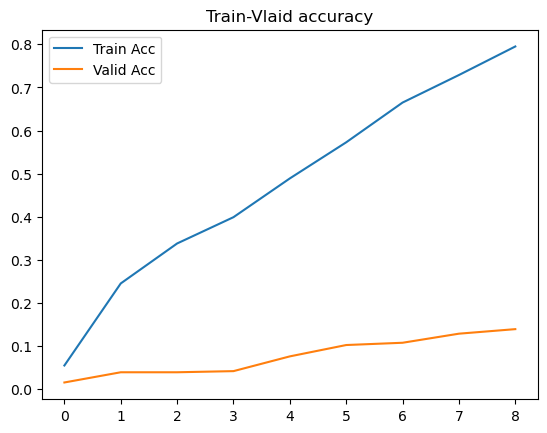

epoch 9 loss: 1.0843: 100%|███████████████████████████████████████| 124/124 [00:57<00:00,  2.15it/s]

train accuracy = 0.83687
[[48  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 1  0  0 ... 34  4  0]
 [ 0  0  0 ...  0 38  5]
 [ 0  0  0 ...  0  0 55]]



epoch 9 loss: 3.7322: 100%|█████████████████████████████████████████| 38/38 [00:03<00:00, 12.31it/s]


validation accuracy = 0.14474
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


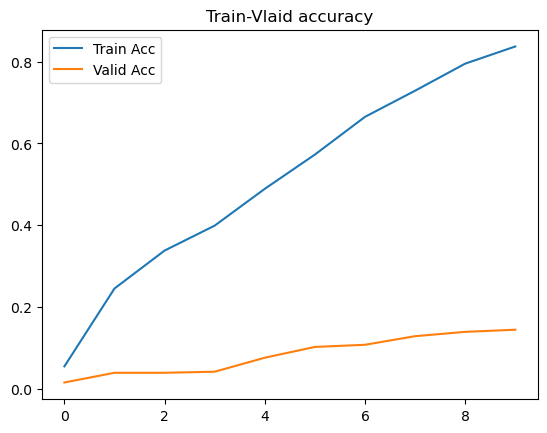

epoch 10 loss: 0.8384: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.87639
[[52  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 42  0  0]
 [ 0  0  0 ...  0 46  3]
 [ 0  0  0 ...  0  0 55]]



epoch 10 loss: 3.6809: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.46it/s]


validation accuracy = 0.15263
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


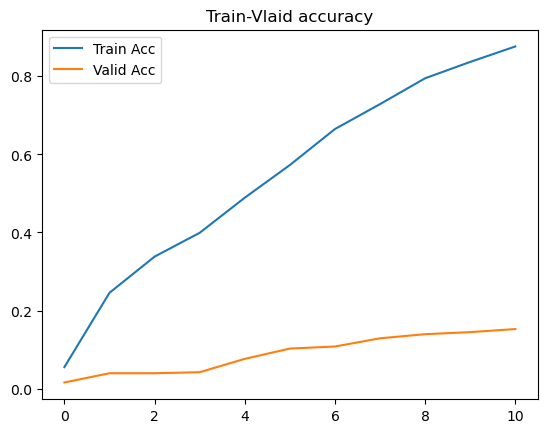

epoch 11 loss: 0.6767: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.90556
[[54  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 47  2  0]
 [ 0  0  0 ...  0 52  2]
 [ 0  0  0 ...  0  0 55]]



epoch 11 loss: 3.6711: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.55it/s]


validation accuracy = 0.16579
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


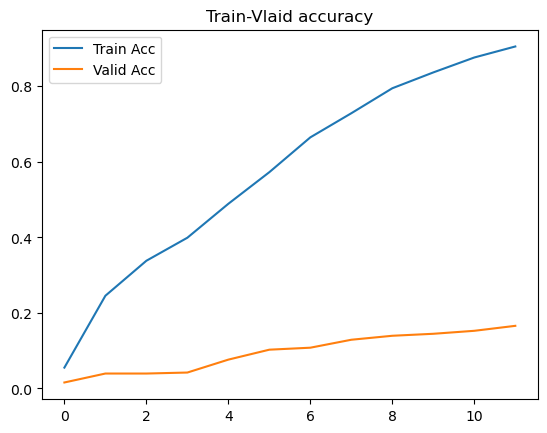

epoch 12 loss: 0.5520: 100%|██████████████████████████████████████| 124/124 [00:58<00:00,  2.13it/s]


train accuracy = 0.93018
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  1  0]
 [ 0  0  0 ...  0 54  0]
 [ 0  0  0 ...  0  0 55]]


epoch 12 loss: 3.6414: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.53it/s]


validation accuracy = 0.17105
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


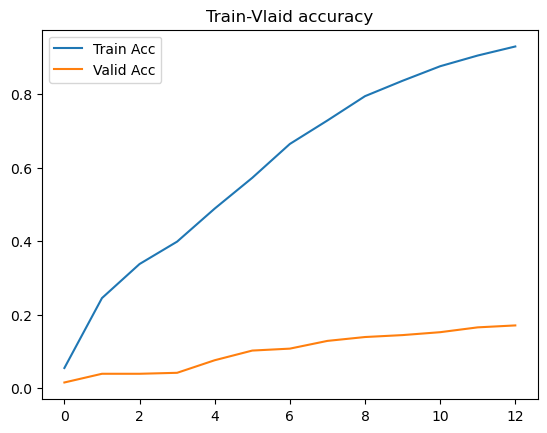

epoch 13 loss: 0.4429: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]

train accuracy = 0.95088
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 54  0]
 [ 0  0  0 ...  0  0 55]]



epoch 13 loss: 3.6443: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.22it/s]


validation accuracy = 0.17895
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


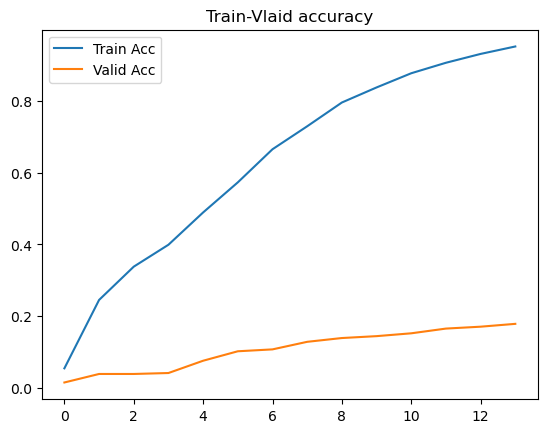

epoch 14 loss: 0.3728: 100%|██████████████████████████████████████| 124/124 [00:56<00:00,  2.18it/s]

train accuracy = 0.96212
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 53  0  0]
 [ 0  0  0 ...  0 53  0]
 [ 0  0  0 ...  0  0 55]]



epoch 14 loss: 3.6753: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.66it/s]


validation accuracy = 0.17895
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 2 0]
 [0 0 0 ... 0 1 1]]


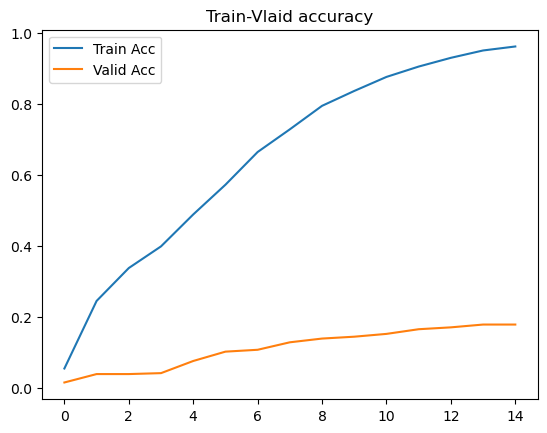

epoch 15 loss: 0.2599: 100%|██████████████████████████████████████| 124/124 [00:56<00:00,  2.18it/s]

train accuracy = 0.96970
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 15 loss: 3.6925: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.07it/s]


validation accuracy = 0.17895
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


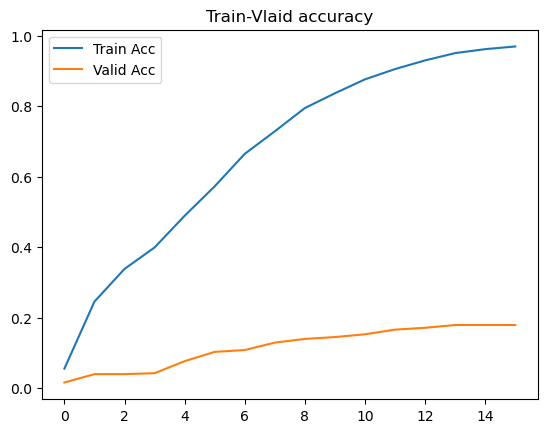

epoch 16 loss: 0.2291: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]


train accuracy = 0.98056
[[53  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 54  0]
 [ 0  0  0 ...  0  0 55]]


epoch 16 loss: 3.7382: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.84it/s]


validation accuracy = 0.18421
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


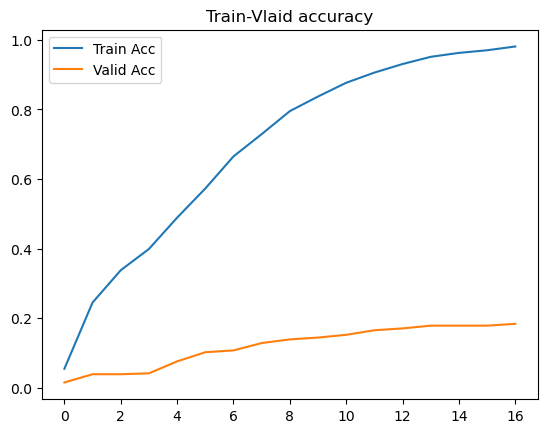

epoch 17 loss: 0.1748: 100%|██████████████████████████████████████| 124/124 [00:58<00:00,  2.10it/s]


train accuracy = 0.98497
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 53  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]


epoch 17 loss: 3.7371: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.84it/s]


validation accuracy = 0.18684
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


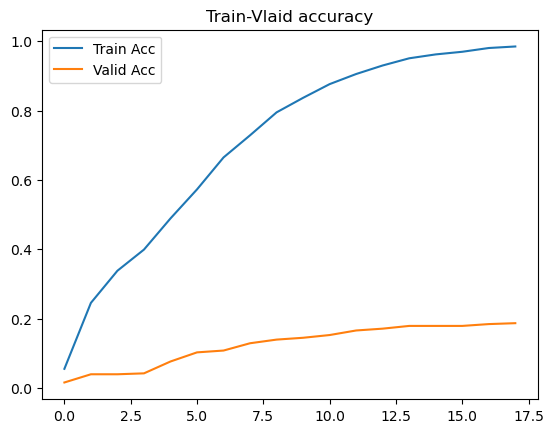

epoch 18 loss: 0.1660: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.98763
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 18 loss: 3.8082: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.58it/s]


validation accuracy = 0.20526
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


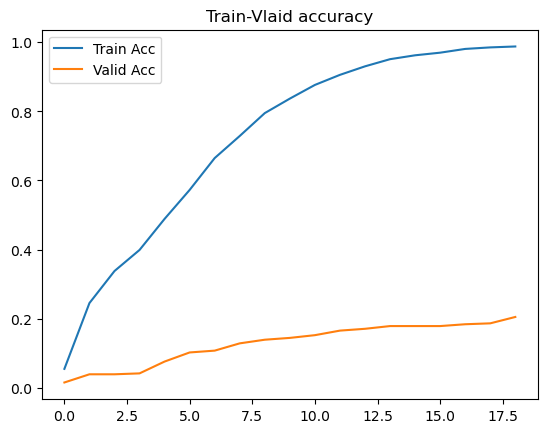

epoch 19 loss: 0.1358: 100%|██████████████████████████████████████| 124/124 [00:58<00:00,  2.14it/s]

train accuracy = 0.99179
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 54 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 53  1]
 [ 0  0  0 ...  0  0 55]]



epoch 19 loss: 3.7892: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.89it/s]


validation accuracy = 0.21579
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


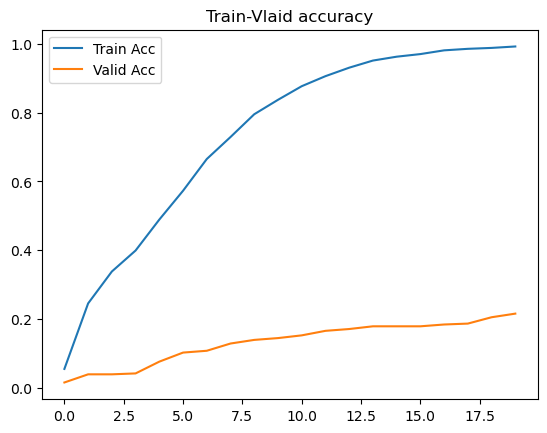

epoch 20 loss: 0.1096: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.99407
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 20 loss: 3.8237: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.29it/s]


validation accuracy = 0.19211
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


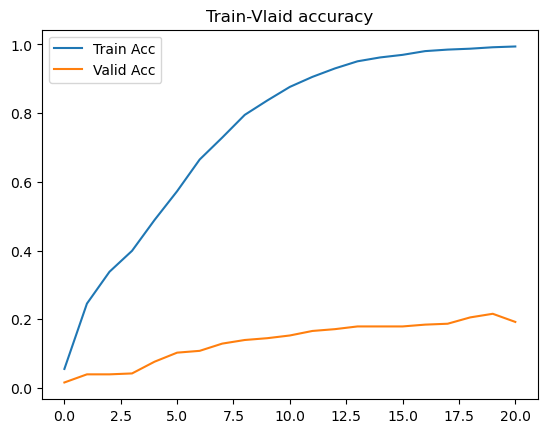

epoch 21 loss: 0.0995: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.14it/s]

train accuracy = 0.99596
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 21 loss: 3.8251: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.99it/s]


validation accuracy = 0.21053
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


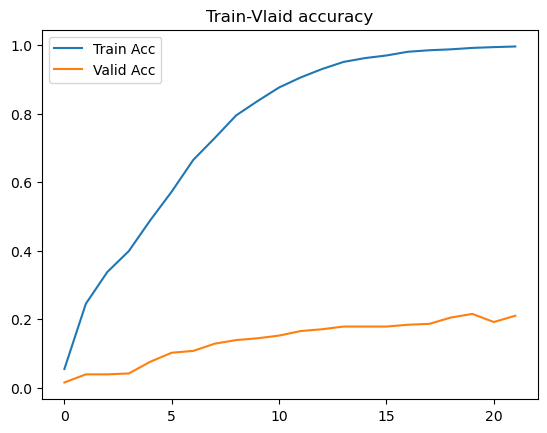

epoch 22 loss: 0.0878: 100%|██████████████████████████████████████| 124/124 [00:58<00:00,  2.13it/s]

train accuracy = 0.99659
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 22 loss: 3.8948: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.35it/s]


validation accuracy = 0.20526
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


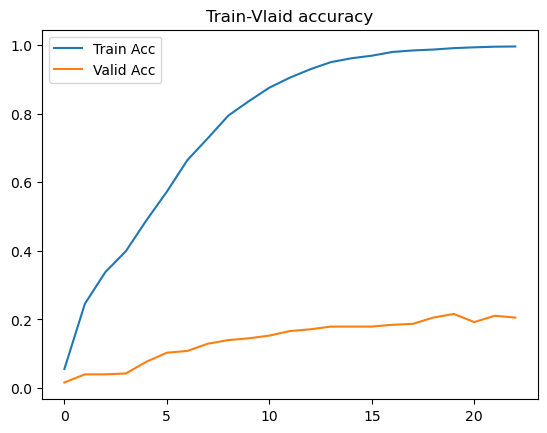

epoch 23 loss: 0.0792: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.15it/s]

train accuracy = 0.99722
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 23 loss: 3.8907: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.44it/s]


validation accuracy = 0.20000
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


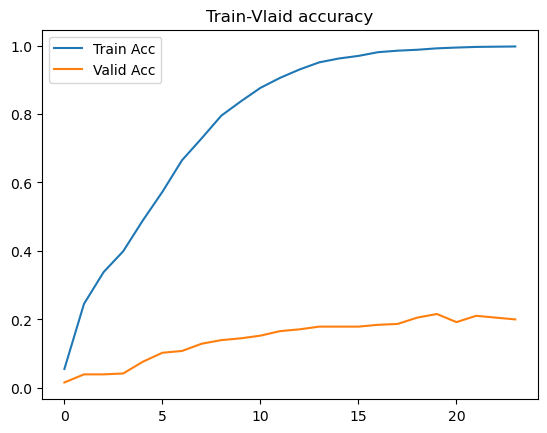

epoch 24 loss: 0.0649: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.99697
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 24 loss: 3.9274: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.03it/s]


validation accuracy = 0.20263
[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


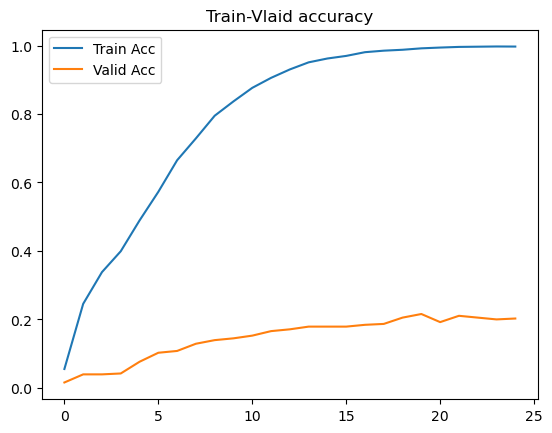

epoch 25 loss: 0.0495: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.99811
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 25 loss: 3.9391: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.26it/s]


validation accuracy = 0.20000
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


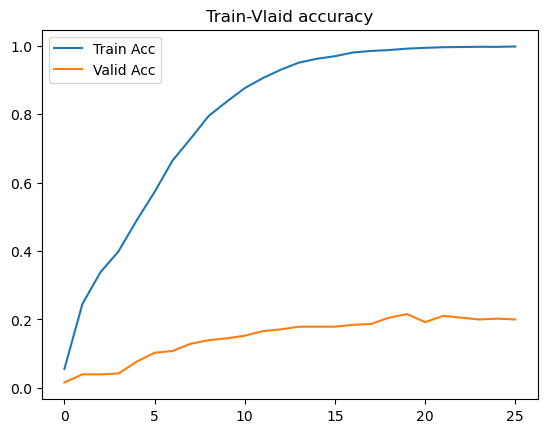

epoch 26 loss: 0.0482: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.14it/s]

train accuracy = 0.99874
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 26 loss: 3.9585: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 12.31it/s]


validation accuracy = 0.21842
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


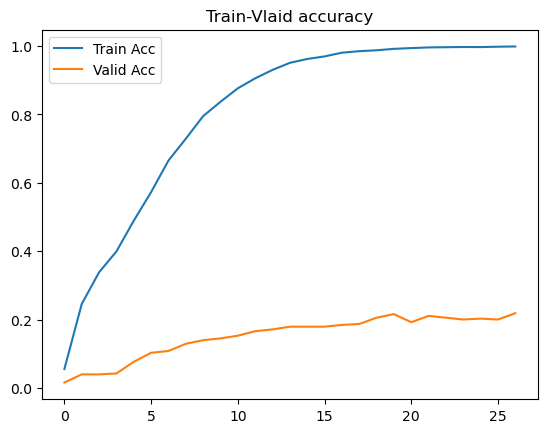

epoch 27 loss: 0.0493: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.17it/s]

train accuracy = 0.99836
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 27 loss: 3.9393: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.61it/s]


validation accuracy = 0.20526
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


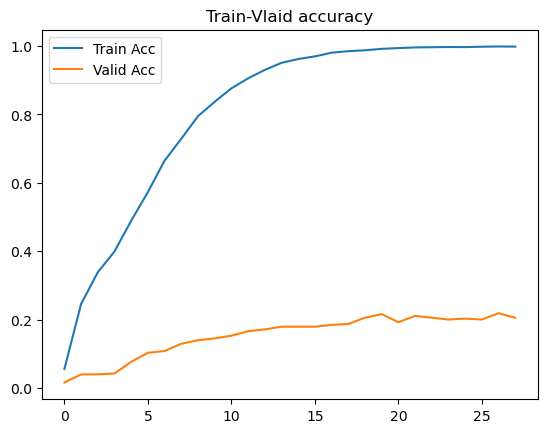

epoch 28 loss: 0.0460: 100%|██████████████████████████████████████| 124/124 [00:57<00:00,  2.16it/s]

train accuracy = 0.99949
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 28 loss: 3.9352: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.64it/s]


validation accuracy = 0.21579
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


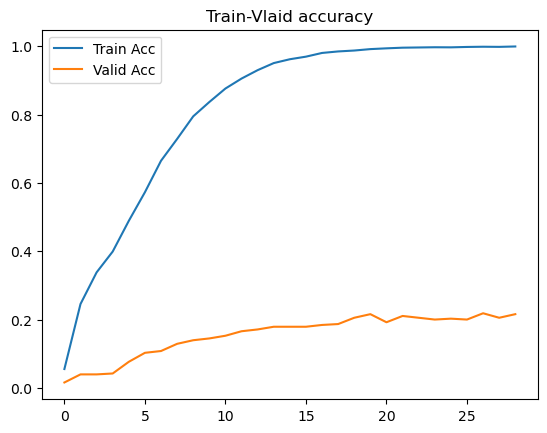

epoch 29 loss: 0.0424: 100%|██████████████████████████████████████| 124/124 [00:58<00:00,  2.14it/s]

train accuracy = 0.99937
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]



epoch 29 loss: 3.9654: 100%|████████████████████████████████████████| 38/38 [00:03<00:00, 11.08it/s]


validation accuracy = 0.21842
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]]


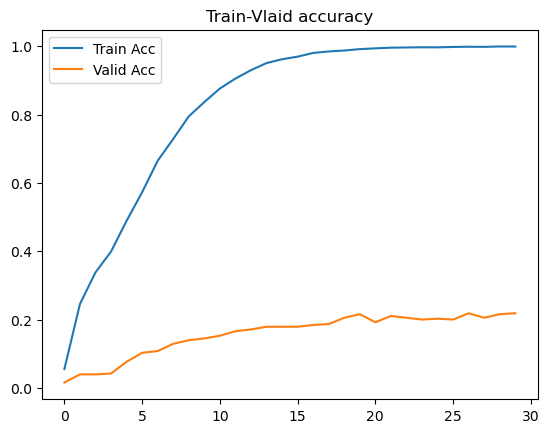

time : 0:30:53
Best Epoch : 26/ 30
Best Train Accuracy : 0.99874
[[55  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0 55 ...  0  0  0]
 ...
 [ 0  0  0 ... 54  0  0]
 [ 0  0  0 ...  0 55  0]
 [ 0  0  0 ...  0  0 55]]
Best Valid Accuracy : 0.21842
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 1]]


In [7]:
%run classification_train_efficientnet2.ipynb

In [20]:
classifier = ForcepImgClassifier('efficientnet_lite0',144)
classifier.load_state_dict(torch.load('efficientnet_lite0/20%_drop_efficientnet_lite0_26 (1)/data.pkl'))

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


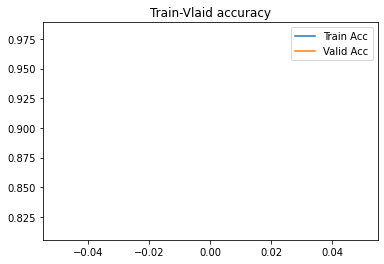

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


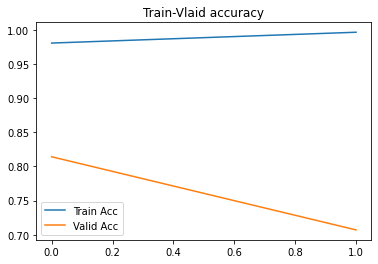

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


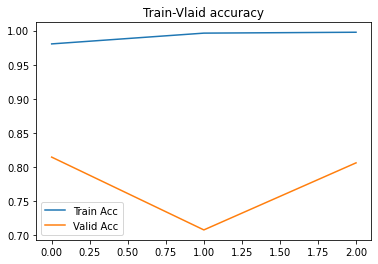

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


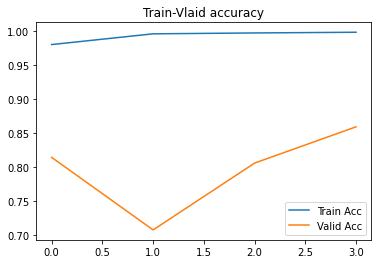

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


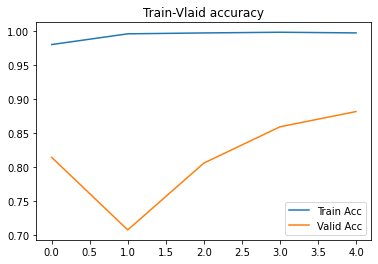

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb